In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

In [21]:
input_dir = '../data/processed/'

X_train = pd.read_csv(f'{input_dir}/X_train.csv')
X_test = pd.read_csv(f'{input_dir}/X_test.csv')
y_train = pd.read_csv(f'{input_dir}/y_train.csv')['credit_status']
y_test = pd.read_csv(f'{input_dir}/y_test.csv')['credit_status']

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

In [10]:
X_test_scaled = scaler.transform(X_test)

In [12]:
log_reg = LogisticRegression(random_state=42, max_iter=100)

In [13]:
rand_forest = RandomForestClassifier(random_state=42)

In [34]:
estimators = range(40, 100, 20)
max_depth = range(1, 8, 2)
min_samples_split = range(2, 10, 2)
min_samples_leaf = range(1, 10)

rand_forest_params = {
    'n_estimators':estimators,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
}

In [16]:
log_reg_params = {
    'penalty':['l1', 'l2'],
    'C':[0.001, 0.01, 0.1, 1, 10, 100],
    'solver':['liblinear'],
}

In [19]:
log_reg_grid_search = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='roc_auc', n_jobs=-1)

In [29]:
log_reg_grid_search.fit(X_train_scaled, y_train)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.001, 0.01, ...], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [30]:
best_log_reg = log_reg_grid_search.best_estimator_

In [35]:
rand_forest_grid_search = GridSearchCV(rand_forest, rand_forest_params, cv=5, scoring='roc_auc', n_jobs=-1)

In [36]:
rand_forest_grid_search.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': range(1, 8, 2), 'min_samples_leaf': range(1, 10), 'min_samples_split': range(2, 10, 2), 'n_estimators': range(40, 100, 20)}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,80


In [38]:
best_rf = rand_forest_grid_search.best_estimator_

In [44]:
def evaluate_model(model, X_test_data, y_test_data, model_name):
    y_pred = model.predict(X_test_data)
    y_pred_proba = model.predict_proba(X_test_data)[:, 1]

    accuracy = accuracy_score(y_test_data, y_pred)
    precision = precision_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred)
    f1 = f1_score(y_test_data, y_pred)
    roc_auc = roc_auc_score(y_test_data, y_pred_proba)

    return roc_auc, y_pred_proba

In [45]:
lr_roc_auc, lr_y_pred_proba = evaluate_model(best_log_reg, X_test_scaled, y_test, 'Tuned Logistic Regression')

In [46]:
rf_roc_auc, rf_y_pred_proba = evaluate_model(best_rf, X_test, y_test, 'Tuned Random Forest')

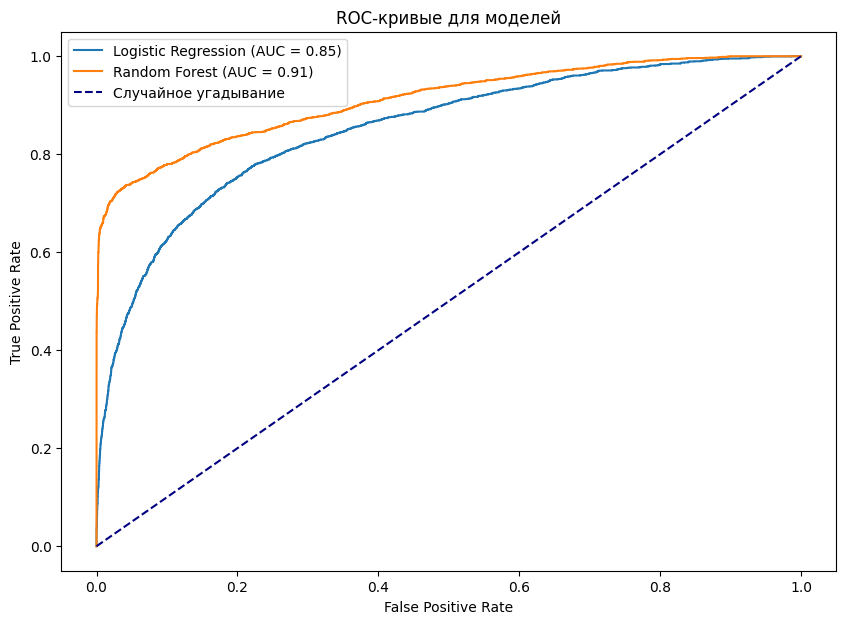

In [50]:
# Рассчитываем ROC-кривые
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_y_pred_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_y_pred_proba)

# Строим график
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_roc_auc:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Случайное угадывание') # Диагональ

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для моделей')
plt.legend()
plt.show()

In [52]:
feature_importances = best_rf.feature_importances_

In [54]:
feature_importances_df = pd.DataFrame({
    'feature':list(X_train),
    'importances':feature_importances,
}).sort_values('importances', ascending=False)

In [55]:
feature_importances_df

,feature,importances
5,credit_percent_income,0.312444
3,credit_grade,0.193471
1,year_income,0.140664
10,home_status_RENT,0.114533
4,percentage_rate,0.108884
9,home_status_OWN,0.025062
2,work_experience,0.024400
13,credit_purpose_MEDICAL,0.018782
6,cb_person_default,0.016697
11,credit_purpose_EDUCATION,0.009696


In [59]:
model_path = '../models/random_forest_model.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(best_rf, f)

In [61]:
columns_path = '../models/model_columns.json'
model_columns = X_train.columns.tolist()

with open(columns_path, 'w') as f:
    json.dump(model_columns, f)